In [15]:
import numpy as np
# import pandas as pd
import matplotlib.pyplot as plt
import os
# import cv2
import random
import tensorflow as tf
from tensorflow import keras

## Dataset creation

In [16]:
emotions_tras = {1:1, 2:4, 3:5, 4:0, 5:3, 6:2, 7:6}
emotions = {0:'angry', 1:'calm', 2:'disgust', 3:'fear', 4:'happy', 5:'sad', 6:'surprise'}
# emotions = {0:'neutral', 1:'calm', 2:'happy', 3:'sad', 4:'angry', 5:'fear', 6:'disgust', 7:'surprise'}
# emotional_intensity = {1:'normal', 2:'strong'}

# dataset_path = "Datasets/RAVDESS_frames/"
dataset_path = "Datasets/RAVDESS_frames_face_BW/"
models_path = "Models/"

height_orig = 224
width_orig = 224
height_targ = 112
width_targ = 112

# batch_size = 64
num_classes = len(emotions)

test_actors = ['23', '24']

In [17]:
filenames_test = [] # test

for dirpath, dirnames, fn in os.walk(dataset_path):
    dirnames.sort()
    # print(dirpath)
    if fn != []:
        class_temp = int(fn[0].split('-')[2]) - 1
        if class_temp != 0:                                                     # exclude 'neutral' label
            if any(act in dirpath for act in test_actors):                      # select only train actors
                path = [os.path.join(dirpath, elem) for elem in fn]
                label = [emotions_tras[class_temp]] * len(fn)                   # emotion trasposition
                filenames_test.append(list(zip(path, label)))
num_videos = len(filenames_test)
num_videos

112

In [18]:
def sampling(list, num_frames_desired):
    tot = []
    for elem in list:
        sampled_list = random.sample(elem, num_frames_desired)
        # tot.append(sampled_list)
        tot += sampled_list
    return(tot)

def parse_image(filename):
    
    image = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image, channels=1)
    image = tf.image.convert_image_dtype(image, dtype=tf.float16)
    image = tf.image.resize_with_crop_or_pad(image, height_orig, width_orig)
    image = tf.image.resize(image, [height_targ, width_targ])
    print('shape frames:', image.shape)
    return image

def configure_for_performance(ds, batch_size):
    # ds = ds.shuffle(buffer_size=1000) # serve?
    ds = ds.batch(batch_size)
    ds = ds.repeat()
    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return ds

def load_dataset(filenames, frames_per_vid):
    print("frames per video:", frames_per_vid) 
    batch_size = frames_per_vid

    filenames_sampled = sampling(filenames, frames_per_vid)
    # random.shuffle(filenames_sampled)
    # print(len(filenames_sampled))

    zipped = [list(t) for t in zip(*filenames_sampled)]

    names = zipped[0]
    labels = zipped[1]

    names = tf.data.Dataset.from_tensor_slices(names)
    images = names.map(parse_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    labels = [elem for elem in labels]
    labels = tf.data.Dataset.from_tensor_slices(labels)

    ds = tf.data.Dataset.zip((images, labels))
    ds = configure_for_performance(ds, batch_size)

    frame_number = len(filenames_sampled)
    step_per_epoch = frame_number // batch_size
    print('frames number:', frame_number, '\nbatch size:', batch_size, '\nbatch number:', step_per_epoch)
    return ds, step_per_epoch

In [19]:
frames_per_vid = min([len(elem) for elem in filenames_test])     # number of frames per clip in order to have balanced classes
test_ds, step_per_epoch_test = load_dataset(filenames_test, frames_per_vid)

frames per video: 24
shape frames: (112, 112, 1)
frames number: 2688 
batch size: 24 
batch number: 112


In [20]:
train_x, train_y = tf.compat.v1.data.make_one_shot_iterator(test_ds).get_next()
train_y

<tf.Tensor: shape=(24,), dtype=int32, numpy=
array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1])>

(112, 112, 1)
calm


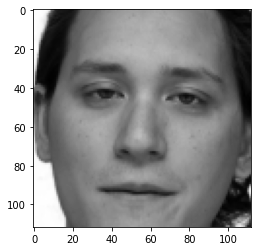

In [21]:
b = test_ds.unbatch().take(1)

for elem in b:
    print(elem[0].shape)
    print(emotions[int(elem[1])])
plt.imshow(elem[0], cmap='gray')

### Load best model

In [22]:
models_list = os.listdir(models_path)

acc = [float(model.split('[')[1].split(']')[0]) for model in models_list]
idx = acc.index(max(acc))                                                       # index of best model

reconstructed_model = keras.models.load_model(models_path + models_list[idx])
reconstructed_model.summary()

Model: "DCNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      832       
                                                                 
 batchnorm_1 (BatchNormaliza  (None, 112, 112, 32)     128       
 tion)                                                           
                                                                 
 activation (Activation)     (None, 112, 112, 32)      0         
                                                                 
 maxpool2d_0 (MaxPooling2D)  (None, 56, 56, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 64)        51264     
                                                                 
 batchnorm_2 (BatchNormaliza  (None, 56, 56, 64)       256       
 tion)                                                        

## Prediction

### Evaluate single frame

In [23]:
loss_single_frame, acc_single_frame = reconstructed_model.evaluate(test_ds, steps=step_per_epoch_test)
print('accuratezza single frame:', round(acc_single_frame, 4))

112/112 [==============================] - 2s 14ms/step - loss: 2.6879 - sparse_categorical_accuracy: 0.4926
accuratezza single frame: 0.4926


In [55]:
predic = reconstructed_model.predict(test_ds, steps=step_per_epoch_test).argmax(axis=1)
ground = [elem[0][1]  for elem in filenames_test]
ground = np.repeat(ground, frames_per_vid)

112/112 [==============================] - 1s 12ms/step


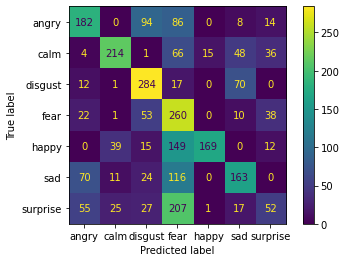

In [64]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(ground, predic)
disp = ConfusionMatrixDisplay(cm, display_labels=list(emotions.values()))
disp.plot()

### Evaluate full video

In [42]:
pred = reconstructed_model.predict(test_ds, steps=step_per_epoch_test)

112/112 [==============================] - 1s 11ms/step


In [25]:
example_id = 0
example = np.array_split(pred, num_videos)[example_id]

print('ground truth:\t', filenames_test[example_id][0][1])

# print('predicted:\t', np.median(o, axis=0).argmax())
# print('predicted:\t', np.sum(o, axis=0).argmax())
print('predicted:\t', np.mean(example, axis=0).argmax())
np.sum(example, axis=0)

ground truth:	 1
predicted:	 3


array([8.5858097e-03, 1.6067922e-01, 9.8875798e-02, 1.8544275e+01,
       1.0584647e-04, 5.1643529e+00, 2.3126161e-02], dtype=float32)

In [26]:
pred_list = np.array_split(pred, num_videos)

ground = []
predic = []

i = 0
for count, video in enumerate(pred_list):
    predic.append(np.sum(video, axis=0).argmax())
    ground.append(filenames_test[count][0][1])
    
    if predic[count] == ground[count]:
        i += 1

print('accuracy full video: ', round(i/len(pred_list), 4), count+1)

accuracy full video:  0.5446 112


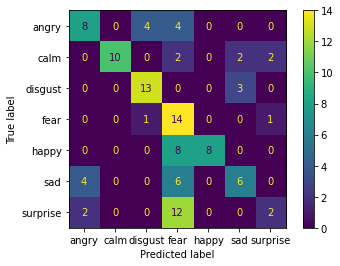

In [39]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(ground, predic)
disp = ConfusionMatrixDisplay(cm, display_labels=list(emotions.values()))
disp.plot()